In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image, ImageOps

# Retrieve Image

Image size 3024x4032
 Resizing to 600x800


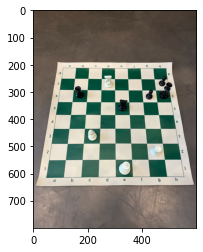

In [ ]:
np.set_printoptions(suppress=True) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

filename = "krish_pieces_perspective.jpg"
img_orig = mpimg.imread(filename)
img_orig = PIL.Image.open(filename)
img_width, img_height = img_orig.size
print("Image size %dx%d" % (img_width, img_height))

aspect_ratio = min(1000/img_width, 800/img_height)
if aspect_ratio < 1.0:
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    print(" Resizing to %dx%d" % (new_width, new_height))
    img_orig = img_orig.resize((new_width,new_height))


img = np.array(img_orig.convert('L')) # grayscale uint8 numpy array

plt.imshow(img_orig);

# Edge Detection [Canny/Hough Transform]
Main purpose is to define prominent edges

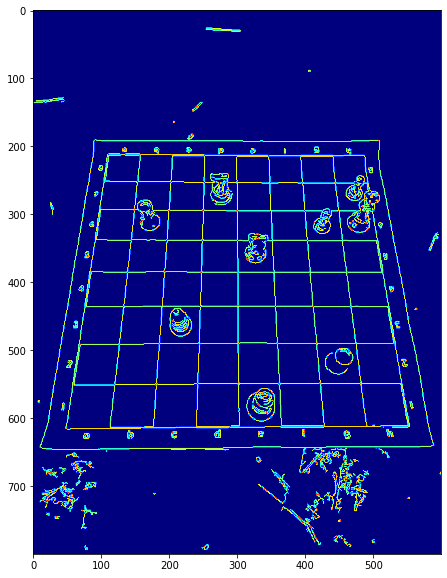

In [ ]:
fig = plt.figure(figsize=(10,10))
edges = cv2.Canny(np.uint8(img),50,150,apertureSize = 3)
plt.imshow(edges);

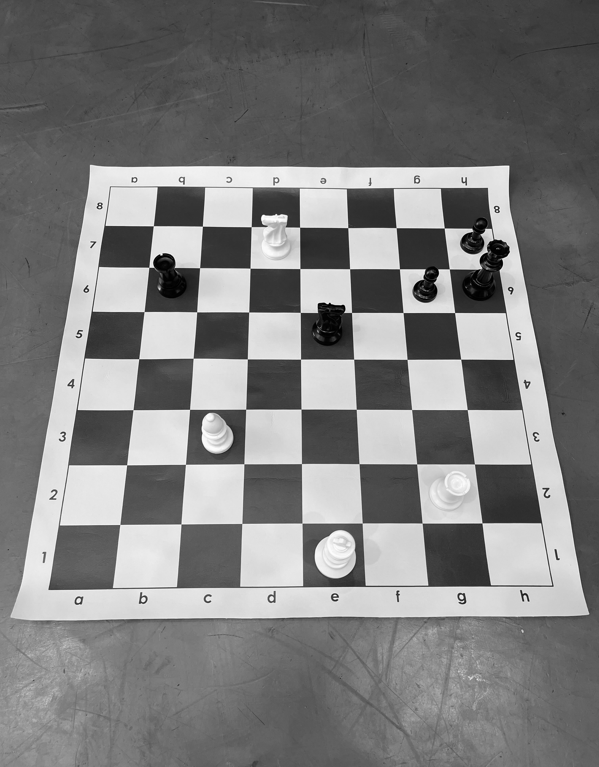

In [ ]:
pts = np.argwhere(edges>0)
y1,x1 = pts.min(axis=0)
y2,x2 = pts.max(axis=0)

## crop the region
cropped = img[y1:y2, x1:x2]
cv2.imwrite("cropped.png", cropped)

tagged = cv2.rectangle(img.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
cv2_imshow(cropped)

edges = cropped
img = cropped

In [ ]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

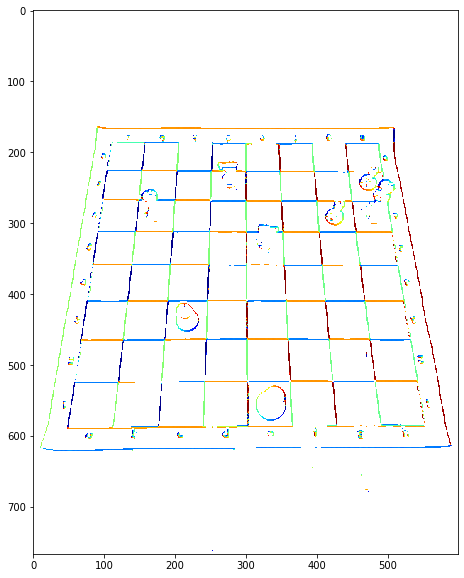

In [ ]:
grad_mag = np.sqrt(sobelx**2+sobely**2)
grad_phase = np.arctan2(sobely, sobelx) # from -pi to pi

# Remove phase from where gradient magnitude is less than the mean * constant
grad_phase_masked = grad_phase.copy()
gradient_mask_threshold = 2*np.mean(grad_mag.flatten())
grad_phase_masked[grad_mag < gradient_mask_threshold] = np.nan

fig = plt.figure(figsize=(10,10))
plt.imshow(grad_phase_masked);

In [ ]:
img_orig = PIL.Image.open("cropped.png")
img_width, img_height = img_orig.size
print("Image size %dx%d" % (img_width, img_height))

aspect_ratio = min(1000/img_width, 800/img_height)
if aspect_ratio < 1.0:
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    print(" Resizing to %dx%d" % (new_width, new_height))
    img_orig = img_orig.resize((new_width,new_height))


# img = np.array(img_orig.convert('L')) # grayscale uint8 numpy array
img_orig = ImageOps.grayscale(img_orig)
img_orig.show()
# plt.imshow(img_orig);

Image size 599x767


# Hough Transform


In [ ]:
def informedHough(bin_img, gradient_phase_img, gradient_magnitude_img, theta_bin_size=100, rho_bin_size=100, inform_range=5):
    """Return informed hough space of input binary image"""
    thetas = np.linspace(0,np.pi,theta_bin_size)
    rho_diagonal = np.sqrt(np.sum(np.array(bin_img.shape)**2))
    rhos = np.linspace(-rho_diagonal,rho_diagonal,rho_bin_size) # length of diagonal
    hough_space = np.zeros([theta_bin_size, rho_bin_size])

    for i in range(bin_img.shape[0]):
        for j in range(bin_img.shape[1]):
            g = gradient_phase_img[i,j]
            if bin_img[i,j] and not np.isnan(g):
                if g < 0:
                    g += np.pi # + 180 degrees
                # Get informed theta range
                theta_idx = np.searchsorted(thetas, g) # Get bin index in thetas
                theta_left = max(0,theta_idx - inform_range)
                theta_right = min(len(thetas)-1,theta_idx + inform_range)
                
                # Over the informed theta sweep range
                for t,theta in enumerate(thetas[theta_left:theta_right]):
                    # TODO continue to use %prun and see if building a cos/sin table is valuable
                    rho = j*np.cos(theta) + i*np.sin(theta)
                    rho_idx = np.searchsorted(rhos, rho) # Get bin index for rhos
                    hough_space[theta_idx-inform_range+t, rho_idx] += gradient_magnitude_img[i,j] # Add gradient magnitude
    return (hough_space, thetas, rhos)

In [ ]:
hough_space, thetas, rhos = informedHough(edges, grad_phase_masked, grad_mag, theta_bin_size=4*360, rho_bin_size=4*360, inform_range=10)

In [ ]:
def filter(neighborhood,center_idx):
    # Definitely not if no hits to hough at this point
    center_val = neighborhood[center_idx]
    if (center_val == 0):
        return False
    neighborhood[center_idx] = 0 # Don't compare to self
    return not np.any(neighborhood >= center_val)


In [ ]:
def getLocalMaxArray(h,winsize=7):
    """Returns matrix with only the peaks of a given input matrix"""
    # winsize needs to be odd to choose center_idx correctly
    center_idx =(winsize+1)*(winsize >> 1)
    return scipy.ndimage.generic_filter(h,
                                        filter,
                                        size=winsize,
                                        mode='wrap',
                                        extra_arguments=(center_idx,)).astype(bool)

In [ ]:
input_hough_space = hough_space.copy()
# Generate peak image
is_peak = getLocalMaxArray(input_hough_space, winsize=11)
local_max_img = input_hough_space.copy() 
local_max_img[~is_peak] = 0 # Set peaks with intensity of peak

# fig = plt.figure(figsi ze=(5,5))
# plt.imshow(local_max_img.T > 0, interpolation='none', cmap=cm.inferno);

Found 923 peaks, 22 strong peaks, keeping only the first 22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Passing 'normal' to axis() is deprecated since 3.1; use 'auto' instead.


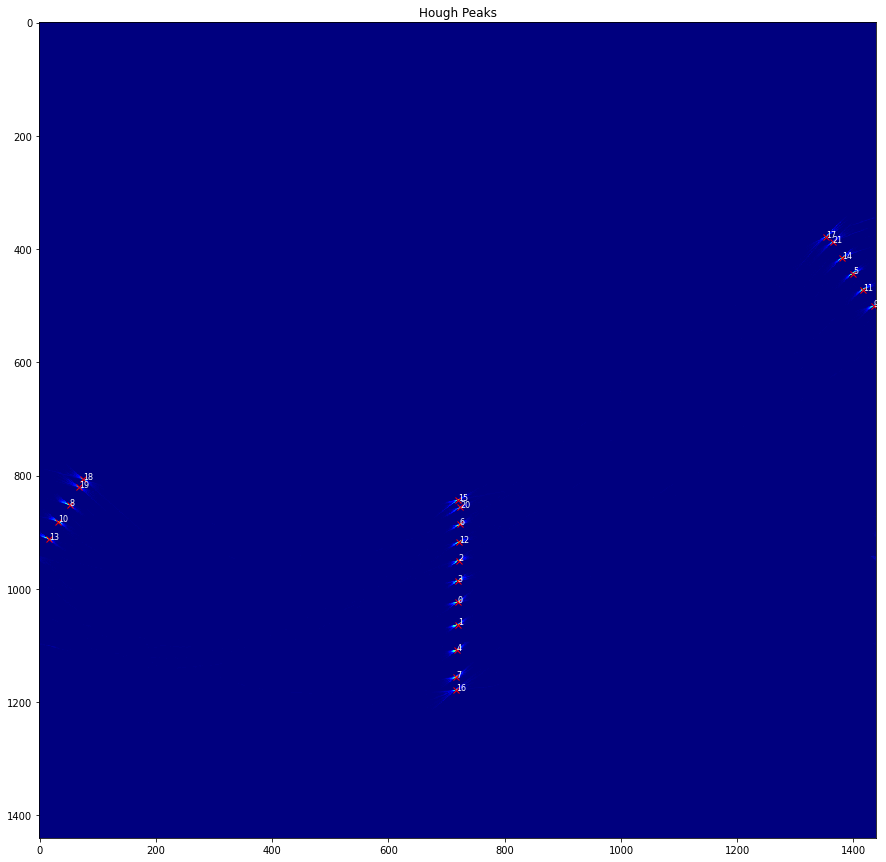

In [ ]:
# local_max_img[local_max_img<100000] = 0
peaks = np.argwhere(local_max_img)

peak_mags = local_max_img[peaks[:,0],peaks[:,1]]
peak_order = np.argsort(peak_mags)[::-1] # Strongest to weakest

# Sort peaks by strength
peaks = peaks[peak_order,:]
peak_mags = peak_mags[peak_order]

fig = plt.figure(figsize=(15,15))

# Only want peaks that are within half a standard deviation of the mean
threshold_good_peak = peak_mags.mean() + peak_mags.std()
n_good_peaks = peaks.shape[0] - np.searchsorted(peak_mags[::-1], threshold_good_peak)

n_peaks = min(n_good_peaks,100)
print("Found",peaks.shape[0],"peaks,",
      n_good_peaks,"strong peaks, keeping only the first",n_peaks)


plt.imshow(input_hough_space.T, interpolation='none')
plt.plot(peaks[:n_peaks,0], peaks[:n_peaks, 1], 'xr')
for idx, [px, py] in enumerate(peaks[:n_peaks,:]):
    plt.text(px, py,'%s' % idx, color='white', size=8)
plt.axis('normal')
plt.axis('tight')
plt.title('Hough Peaks');

In [ ]:
def getHoughLines(peaks, thetas, rhos, img_shape):
    # lines segments within image bounds x1 y1 x2 y2
    lines = np.zeros([peaks.shape[0],4])
    
    for i, [theta_, rho_] in enumerate(peaks):
        theta = thetas[theta_]
        rho = rhos[rho_]
        c = np.cos(theta)
        s = np.sin(theta)
        
        img_x_max = img_shape[1]-1
        img_y_max = img_shape[0]-1

        if np.abs(c) < np.abs(s):
            x1 = 0
            x2 = img_x_max
            y1 = (rho - x1*c)/s
            y2 = (rho - x2*c)/s
        else:
            y1 = 0
            y2 = img_y_max
            x1 = (rho - y1*s)/c
            x2 = (rho - y2*s)/c
        
        if (np.abs(s) > 0.01 and np.abs(c) > 0.01):
            if (y1 < 0):
                x1 = (rho - 0*s)/c
                y1 = (rho - x1*c)/s
            elif (y1 > img_y_max):
                x1 = (rho - img_y_max*s)/c
                y1 = (rho - x1*c)/s
            if (y2 < 0):
                x2 = (rho - 0*s)/c
                y2 = (rho - x2*c)/s
            elif (y2 > img_y_max):
                x2 = (rho - img_y_max*s)/c
                y2 = (rho - x2*c)/s

            if (x1 < 0):
                y1 = (rho-0*c)/s
                x1 = (rho - y1*s)/c
            elif (x1 > img_x_max):
                y1 = (rho - img_x_max*c)/s
                x1 = (rho - y1*s)/c
            if (x2 < 0):
                y2 = (rho-0*c)/s
                x2 = (rho - y2*s)/c
            elif (x2 > img_x_max):
                y2 = (rho - img_x_max*c)/s
                x2 = (rho - y2*s)/c

        lines[i,:] = [x1, y1, x2, y2]

    return lines

# Filtering Out Lines 


basically we want to identify which lines belong to the chess board specifically. in order to do so we are filtering out lines based on confidence score and their distances to adjacent lines

In [ ]:
# take the high confidence lines; find avg dist and avg mean
# remove any lines that aren't within 1 std of the mean (dist)
# take lower confidence lines and see if there are any that fit that have good distance from the pre-existing lines
# if they have good distance (close to mean) then add them to the final lines list

# shouldn't be removing the lines that are already high confidence; just find what other lines work in that setting and don't intersect


In [ ]:
# take the highest confidence lines
# at any given time, we want 9 vertical lines and 9 horizontal lines
# one iteration (do until we have 9 vertical/9 horizontal that are equidistant):
    # HOW DO WE FILTER OUT LINES?
        # we take average distance between lines
        # if there is a line that is much less than that distance, we see which one has mean distance to another line
        # remove the one that doesn't have that mean distance
    # keep track of the lines that we are removing; add them to a list of skipped indices (skip over them when we get highest confidence lines)
    # extend confidence threshold by the number that we removed
    # repeat and stop when we have the grid


In [ ]:
def get_slope(line):
    m = abs(((line[3] - line[1]) / (line[0] - line[2])))
    if m > 3:
        return "vert"
    if m < 0.5:
        return "hor"
    return None

In [ ]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [ ]:
def filter_lines(lns):

    init_vert_lines = []
    init_hor_lines = []

    vert_def_lines = []
    hor_def_lines = []

    vert_def_dists = []
    hor_def_dists = []


    # NEED TO SPLIT LINES INTO VERTICAL/HORIZONTAL LISTS (WE WANT 9 EACH) 
    
    for i in lns:
        if get_slope(i) == "vert":
            init_vert_lines.append(i)
        if get_slope(i) == "hor":
            init_hor_lines.append(i)
        

    # FIRST ITERATION TO GET HIGHEST CONFIDENCE LINES FROM WHICH WE REMOVE AND ITERATE UPON 
    # SPLIT UP FOR VERTICAL/HORIZONTAL

    for i, [x1,y1,x2,y2] in enumerate(init_vert_lines):
        if i < 12 and x1 >= 0:
            vert_def_lines.append(init_vert_lines[i])
            # alpha_ = 1.0 if i < min(peaks.shape[0], 20) else 0.3 # Make first 20 lines strongest

    for i, [x1,y1,x2,y2] in enumerate(init_hor_lines):
        if i < 12:
            hor_def_lines.append(init_hor_lines[i])
            # alpha_ = 1.0 if i < min(peaks.shape[0], 20) else 0.3 # Make first 20 lines strongest

    
    # SORT THE LINES IN ORDER FROM (TOP TO BOTTOM) AND (LEFT TO RIGHT)
    
    for i in range(len(vert_def_lines)):
        for j in range(len(vert_def_lines)):
            if vert_def_lines[i][0] < vert_def_lines[j][0]:
                temp = vert_def_lines[i].copy()
                vert_def_lines[i] = vert_def_lines[j]
                vert_def_lines[j] = temp

    for i in range(len(hor_def_lines)):
        for j in range(len(hor_def_lines)):
            if hor_def_lines[i][1] < hor_def_lines[j][1]:
                temp = hor_def_lines[i].copy()
                hor_def_lines[i] = hor_def_lines[j]
                hor_def_lines[j] = temp

    # FIRST REMOVAL (TARGET INTERSECTING LINES)

    vert_line_ints = []
    vert_ints_lines = []

    for i, [f_x1,f_y1,f_x2,f_y2] in enumerate(vert_def_lines):
      for j, [x1,y1,x2,y2] in enumerate(vert_def_lines):
        if i != j:
          try:
            inter = line_intersection(([f_x1, f_y1], [f_x2, f_y2]), ([x1, y1], [x2, y2]))
            if ((inter[0] < img.shape[1]) and (inter[1] < img.shape[0]) and (inter[0] > 0) and (inter[1] > 0)):
                vert_line_ints.append(inter)
                vert_ints_lines.append(sorted([i, j]))
          except:
            continue
        
    vert_lines_clean = []
    [vert_lines_clean.append((vert_line_ints[x], vert_ints_lines[x])) for x in range(len(vert_line_ints)) if (vert_line_ints[x], vert_ints_lines[x]) not in vert_lines_clean]
    vert_line_ints = vert_lines_clean

    print(f"VERT_LINE_INTS: {vert_line_ints}")

    if len(vert_line_ints) > 0:
        for i in range(len(vert_line_ints)):
            print(vert_line_ints[i][1][0])
            new_x0 = [(vert_def_lines[vert_line_ints[i][1][0]] + vert_def_lines[vert_line_ints[i][1][1]])/2] # AVG OF THE 2 INTERSECTING LINES
            print(new_x0)
            del vert_def_lines[vert_line_ints[i][1][0]]
            del vert_def_lines[vert_line_ints[i][1][0]]
            vert_def_lines.insert(vert_line_ints[i][1][0], new_x0[0])


    hor_line_ints = []
    hor_ints_lines = []

    for i, [f_x1,f_y1,f_x2,f_y2] in enumerate(hor_def_lines):
      for j, [x1,y1,x2,y2] in enumerate(hor_def_lines):
        if i != j:
          try:
            inter = line_intersection(([f_x1, f_y1], [f_x2, f_y2]), ([x1, y1], [x2, y2]))
            if ((inter[0] < img.shape[1]) and (inter[1] < img.shape[0]) and (inter[0] > 0) and (inter[1] > 0)):
                hor_line_ints.append(inter)
                hor_ints_lines.append(sorted([i, j]))
          except:
            continue
        
    hor_lines_clean = []
    [hor_lines_clean.append((hor_line_ints[x], hor_ints_lines[x])) for x in range(len(hor_line_ints)) if (hor_line_ints[x], hor_ints_lines[x]) not in hor_lines_clean]
    hor_line_ints = hor_lines_clean

    print(f"HOR_LINE_INTS: {hor_line_ints}")

    if len(hor_line_ints) > 0:
        for i in range(len(hor_line_ints)):
            print(hor_line_ints[i][1][0])
            new_x0 = [(hor_def_lines[hor_line_ints[i][1][0]] + hor_def_lines[hor_line_ints[i][1][1]])/2] # AVG OF THE 2 INTERSECTING LINES
            print(new_x0)
            del hor_def_lines[hor_line_ints[i][1][0]]
            del hor_def_lines[hor_line_ints[i][1][0]]
            hor_def_lines.insert(hor_line_ints[i][1][0], new_x0[0])

    print("END OF INTS REMOVAL")
    print(vert_def_lines)
    print(hor_def_lines)


    # SECOND REMOVAL (TARGET LINES NOT WITHIN MEAN DISTANCE)

    for i in range(len(vert_def_lines) - 1):
        vert_def_dists.append(vert_def_lines[i+1][0] - vert_def_lines[i][0])

    for i in range(len(hor_def_lines) - 1):
        hor_def_dists.append(hor_def_lines[i+1][1] - hor_def_lines[i][1])

    vert_def_dists = np.array(vert_def_dists)
    hor_def_dists = np.array(hor_def_dists)

    mean_vert_dist = np.mean(vert_def_dists)
    mean_hor_dist = np.mean(hor_def_dists)

    print(vert_def_dists)
    print(f"MEAN_VERT_DIST: {np.mean(vert_def_dists)}")
    print(hor_def_dists)
    print(f"MEAN_HOR_DIST: {np.mean(hor_def_dists)}")

    for i in range(len(vert_def_dists)):
        if vert_def_dists[i] < mean_vert_dist * 0.6:
            if i == 0:
                del vert_def_lines[0]
            if i == len(vert_def_dists) - 1:
                del vert_def_lines[len(vert_def_lines) - 1]

    for i in range(len(hor_def_dists)):
        if hor_def_dists[i] < mean_hor_dist * 0.7:
            if i == 0:
                del hor_def_lines[0]
            if i == len(hor_def_dists) - 1:
                del hor_def_lines[len(hor_def_lines) - 1]

    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='Greys');
    plt.axis([0,img.shape[1],img.shape[0],0])

    for i, [x1,y1,x2,y2] in enumerate(vert_def_lines):
        plt.plot([x1,x2], [y1,y2], lw=5)
    
    for i, [x1,y1,x2,y2] in enumerate(hor_def_lines):
        plt.plot([x1,x2], [y1,y2], lw=5)

    # print(len(vert_def_lines))
    # print(len(hor_def_lines))
    # print(vert_def_lines)
    # print(hor_def_lines)

    return np.concatenate((vert_def_lines, hor_def_lines))


VERT_LINE_INTS: []
HOR_LINE_INTS: []
END OF INTS REMOVAL
[array([118.58476724,   0.        ,   0.        , 717.74953465]), array([137.44670255,   0.        ,  22.88650004, 766.        ]), array([180.37873084,   0.        ,  93.04288129, 766.        ]), array([218.97676621,   0.        , 165.37548388, 766.        ]), array([260.53169814,   0.        , 233.76378476, 766.        ]), array([296.90390644,   0.        , 303.59333283, 766.        ]), array([335.18746259,   0.        , 373.68304572, 766.        ]), array([375.42055025,   0.        , 442.48367549, 766.        ]), array([413.93895516,   0.        , 513.1548031 , 766.        ]), array([454.46069758,   0.        , 581.01728497, 766.        ]), array([470.17080346,   0.        , 598.        , 672.8170465 ])]
[array([  0.        , 167.04444719, 598.        , 167.69721757]), array([  0.        , 184.63335325, 598.        , 189.20283303]), array([  0.        , 225.21211221, 598.        , 229.78159199]), array([  0.        , 267.139676

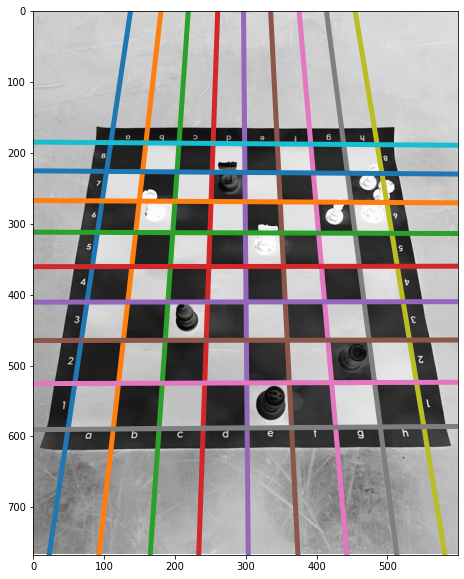

In [ ]:
lines = getHoughLines(peaks[:n_peaks], thetas, rhos, img.shape)

final_lines = filter_lines(lines)

In [ ]:
final_lines

array([[137.44670255,   0.        ,  22.88650004, 766.        ],
       [180.37873084,   0.        ,  93.04288129, 766.        ],
       [218.97676621,   0.        , 165.37548388, 766.        ],
       [260.53169814,   0.        , 233.76378476, 766.        ],
       [296.90390644,   0.        , 303.59333283, 766.        ],
       [335.18746259,   0.        , 373.68304572, 766.        ],
       [375.42055025,   0.        , 442.48367549, 766.        ],
       [413.93895516,   0.        , 513.1548031 , 766.        ],
       [454.46069758,   0.        , 581.01728497, 766.        ],
       [  0.        , 184.63335325, 598.        , 189.20283303],
       [  0.        , 225.21211221, 598.        , 229.78159199],
       [  0.        , 267.13967661, 598.        , 270.40355962],
       [  0.        , 311.77270119, 598.        , 313.73101855],
       [  0.        , 360.46433341, 598.        , 359.81156303],
       [  0.        , 410.51003823, 598.        , 409.85726785],
       [  0.        , 464

In [ ]:
line_ints = []
ints_lines = []

for i, [f_x1,f_y1,f_x2,f_y2] in enumerate(final_lines):
  for j, [x1,y1,x2,y2] in enumerate(final_lines):
    if i != j:
      try:
        inter = line_intersection(([f_x1, f_y1], [f_x2, f_y2]), ([x1, y1], [x2, y2]))
        if ((inter[0] < img.shape[1]) and (inter[1] < img.shape[0]) and (inter[0] > 0) and (inter[1] > 0)):
            line_ints.append(inter)
            ints_lines.append([i, j])
      except:
        continue
      
lines_clean = []
[lines_clean.append(x) for x in line_ints if x not in lines_clean]
line_ints = np.array(lines_clean)

In [ ]:
line_ints.shape

(81, 2)

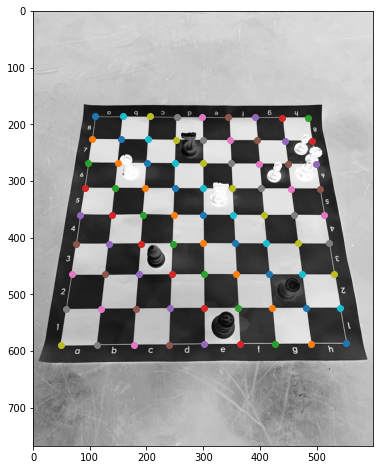

In [ ]:
plt.figure(figsize=(16,8))
plt.axis([0,img.shape[1],img.shape[0],0])
plt.imshow(img, cmap="Greys")

for i in line_ints:
    plt.scatter(i[0], i[1])

In [ ]:
set_points = []

alter_rows = line_ints.copy()

for i in range(len(alter_rows)):
    for j in range(len(alter_rows)):
        if alter_rows[i][1] > alter_rows[j][1]:
            temp = alter_rows[i].copy()
            alter_rows[i] = alter_rows[j]
            alter_rows[j] = temp

alter_rows = np.array(alter_rows)

alter_rows = alter_rows.reshape([9, 9, 2])

print(alter_rows.shape)

for i in range(len(alter_rows)):
    for j in range(len(alter_rows[i])):
        for k in range(len(alter_rows[i])):
            # print(alter_rows[i][j][0])
            if alter_rows[i][j][0] < alter_rows[i][k][0]:
                temp = alter_rows[i][j].copy()
                alter_rows[i][j] = alter_rows[i][k]
                alter_rows[i][k] = temp

print(alter_rows)

(9, 9, 2)
[[[ 49.20169952 590.04497932]
  [113.16019768 589.55625514]
  [177.75677445 589.06265522]
  [239.96348102 588.58731694]
  [302.03985742 588.11297456]
  [364.71920469 587.63402471]
  [426.82622598 587.15944816]
  [489.92809717 586.67726969]
  [551.31253979 586.20821456]]

 [[ 58.88628607 525.28956573]
  [120.51060344 525.08775976]
  [182.24760117 524.88558478]
  [242.19640203 524.68926576]
  [301.48428691 524.49511109]
  [361.53625466 524.29845421]
  [421.30562406 524.10272278]
  [481.79749516 523.90462532]
  [540.98687352 523.71079324]]

 [[ 67.97187629 464.53930554]
  [127.42146285 464.47441101]
  [186.47941827 464.40994398]
  [244.30507214 464.34682211]
  [300.95847589 464.28497987]
  [358.51710011 464.22214949]
  [416.05759448 464.1593389 ]
  [474.05081097 464.09603413]
  [531.12717973 464.03373018]]

 [[ 76.06471689 410.4270068 ]
  [133.5908626  410.36421188]
  [190.26562795 410.30234631]
  [246.1957929  410.24129355]
  [300.48599848 410.18203094]
  [355.79826177 410.1216